<h1>Cousera IBM DATA SCIENCE The capstone project

<h2>Real Estate in Val de Marne France

<h3>Import modules 

In [1]:
import os
import requests
from urllib.request import urlretrieve
import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import geopandas as gpd
from bs4 import BeautifulSoup
from shapely.geometry import Point,Polygon
from shapely import speedups
from branca.element import Template, MacroElement
import json
#!conda install -c conda-forge geopy --yes    # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.pyplot as plt
import matplotlib.cm as  cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes    # uncomment this line if you haven't completed the Foursquare API lab
import folium

<h3>Population Density in Val de Marne

In [2]:
url='https://public.opendatasoft.com/explore/dataset/code-insee-postaux-geoflar/download/?format=csv&q=94&refine.nom_region=ILE-DE-FRANCE&refine.nom_dept=VAL-DE-MARNE&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B'
df = pd.read_csv(url,sep=';')
df.head(1)

,CODE INSEE,NOM DE LA COMMUNE,CODE POSTAL,LIBELLE D'ACHEMINEMENT,Y Centroid,Nom Region,Nom Dept,STATUT,Code Region,Code Commune,Z Moyen,Code Dept,X Centroid,Geometry X Y,Geometry,Id Geofla,X Chef Lieu,Code Canton,Superficie,Population,Nom Commune,Code Arrondissement,Y Chef Lieu,Code commune complet
0,94016,CACHAN,94230,CACHAN,68548,ILE-DE-FRANCE,VAL-DE-MARNE,Chef-lieu canton,11,16,62,94,6508,"48.7916121646,2.33153313164","{""type"": ""Polygon"", ""coordinates"": [[[2.325812...",16649,6509,5,278,27.8,CACHAN,3,68548,94016


In [3]:
geo=df.loc[:,['CODE INSEE','NOM DE LA COMMUNE', 'Geometry X Y','Population','Superficie']]
geo['Densite']=geo['Population']/geo['Superficie']*1000
geo.drop(['Population', 'Superficie'], axis=1,inplace=True)
geo.rename(columns={'CODE INSEE':'code'},inplace=True)
df2=geo['Geometry X Y'].str.split(",", expand=True)
df2=df2.join(geo)
df2.rename(columns={0:'X',1:'Y'},inplace=True)
df2=df2.astype({'X': float,'Y': float })
geod=df2.astype({'code': str})
geod.head()

,X,Y,code,NOM DE LA COMMUNE,Geometry X Y,Densite
0,48.791612,2.331533,94016,CACHAN,"48.7916121646,2.33153313164",100.000000
1,48.720869,2.531577,94075,VILLECRESNES,"48.7208692486,2.53157741439",16.843972
2,48.764315,2.417425,94022,CHOISY LE ROI,"48.764315118,2.41742518222",72.828096
3,48.735618,2.576375,94070,SANTENY,"48.7356177142,2.57637480242",3.696304
4,48.851105,2.473954,94033,FONTENAY SOUS BOIS,"48.8511046382,2.47395409774",95.691203


In [4]:
#!wget --quiet https://github.com/gregoiredavid/france-geojson/raw/master/departements/94-val-de-marne/communes-94-val-de-marne.geojson val_de_marne.json

url='https://github.com/gregoiredavid/france-geojson/raw/master/departements/94-val-de-marne/communes-94-val-de-marne.geojson '
nom_fichier='val_de_marne.json'    
urlretrieve(url, nom_fichier)  # recuperation des fichiers
print('GeoJSON file downloaded!') 

GeoJSON file downloaded!


In [5]:
latitude=48.7842
longitude=2.4712

m = folium.Map(location=[latitude,longitude],zoom_start=11)
geo2=r'val_de_marne.json'
m.choropleth(
    geo_data=geo2,
    name='Densite par commune',
    data=geod,
    columns=['code', 'Densite'],
    key_on='feature.properties.code',
    fill_color='YlOrRd', 
    #fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Densite par commune'
)
m
#folium.LayerControl().add_to(m)

<h3>Metro and RER Stations in Ile de france<a id="1"></a>

In [6]:
url='https://data.iledefrance-mobilites.fr/explore/dataset/emplacement-des-gares-idf/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B'
da = pd.read_csv(url,sep=';')
da.head(2)  
    

,Geo Point,Geo Shape,OBJECTID,id_ref_zdl,gares_id,nom_gare,nomlong,nom_iv,num_mod,mode_,fer,train,rer,metro,tramway,navette,val,terfer,tertrain,terrer,termetro,tertram,ternavette,terval,idrefliga,idrefligc,ligne,cod_ligf,ligne_code,indice_lig,reseau,res_com,cod_resf,res_stif,exploitant,num_psr,idf,principal,x,y
0,"48.8701642009,2.35049797186","{""type"": ""Point"", ""coordinates"": [2.3504979718...",2,45100,91,Bonne Nouvelle,BONNE NOUVELLE,Bonne Nouvelle,2240,Metro,0,0,0,1,0,0,0,0,0,0,0,0,0,0,A01542,NaN,9,16.0,9-108047,9,METRO,M9,3.0,110.0,RATP,0,1,0,652356.5489,6.863545e+06
1,"48.8407450152,2.2285369815","{""type"": ""Point"", ""coordinates"": [2.2285369815...",7,42381,100,Boulogne-Pont de Saint-Cloud,BOULOGNE-PONT DE SAINT CLOUD,Boulogne-Pont de Saint-Cloud,2263,Metro,0,0,0,1,0,0,0,0,0,0,M10,0,0,0,A01543,NaN,10,2.0,10-110023,10,METRO,M10,3.0,110.0,RATP,0,1,0,643378.5475,6.860354e+06


<h3>Cleaning

In [7]:
cols=['Geo Point',   'nom_gare', 'mode_', 'ligne']
da = da[cols]
da.head(2)

,Geo Point,nom_gare,mode_,ligne
0,"48.8701642009,2.35049797186",Bonne Nouvelle,Metro,9
1,"48.8407450152,2.2285369815",Boulogne-Pont de Saint-Cloud,Metro,10


<h3>Only metro and RER

In [8]:
db=da.loc[da['mode_'].isin(['Metro','RER']),:]
db.head(2)

,Geo Point,nom_gare,mode_,ligne
0,"48.8701642009,2.35049797186",Bonne Nouvelle,Metro,9
1,"48.8407450152,2.2285369815",Boulogne-Pont de Saint-Cloud,Metro,10


<h3> Splitting coords

In [9]:
dc=db['Geo Point'].str.split(",", expand=True)
db=db.join(dc)
db.rename(columns={'nom_gare':'gare','mode_':'type',0:'Latitude',1:'Longitude'},inplace=True)
db=db.astype({'Latitude': float, 'Longitude':float})
db.drop(['Geo Point'], axis=1,inplace=True)
db.head(2)

,gare,type,ligne,Latitude,Longitude
0,Bonne Nouvelle,Metro,9,48.870164,2.350498
1,Boulogne-Pont de Saint-Cloud,Metro,10,48.840745,2.228537


<h3>Fetching Polygone Val de marne <a id="2"></a>

In [10]:
#url='https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson'
url='https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements.geojson'
nom_fichier='departements.json'    
urlretrieve(url, nom_fichier)  # recuperation des fichiers
print('GeoJSON file downloaded!') 

GeoJSON file downloaded!


In [11]:
geo = json.load(open("departements.json"))
geo["features"][94]['properties']['nom']

'Val-de-Marne'

In [12]:
contour=geo["features"][94]['geometry']['coordinates'][0]
#inversion des coordonnees pour cartographie polyline
cont_xy=[]
for i in range (len(contour)):
    cont_xy.append([contour[i][1],contour[i][0]])
polygone_94=Polygon(contour)


In [13]:
def in_poly (x,y,poly):
    point=Point([x,y])
    if point.within(poly):
        r=1
    else:
        r=0
    return r

<h3>Restriction to Val de Marne

In [14]:
db['Z'] = db.apply(lambda row: in_poly(row['Longitude'], row['Latitude'],polygone_94), axis=1)
db.head(2)

,gare,type,ligne,Latitude,Longitude,Z
0,Bonne Nouvelle,Metro,9,48.870164,2.350498,0
1,Boulogne-Pont de Saint-Cloud,Metro,10,48.840745,2.228537,0


In [15]:
db=db[db['Z']==1]
db=db.reset_index(drop=True)
db.head(55)
db.shape

(53, 6)

<h3>Splitting Metro and RER 

In [16]:
dmetro=db[db['type']=='Metro']
dmetro.head()

,gare,type,ligne,Latitude,Longitude,Z
0,Bérault,Metro,1,48.845471,2.429205,1
1,Créteil-Université,Metro,8,48.789978,2.450453,1
2,Villejuif-Louis Aragon,Metro,7,48.787563,2.367804,1
10,Créteil-L'Échat (Hôpital Mondor),Metro,8,48.796741,2.449433,1
11,Villejuif-Léo Lagrange,Metro,7,48.804688,2.363953,1


In [17]:
drer=db[db['type']=='RER']
drer.head()

,gare,type,ligne,Latitude,Longitude,Z
3,BRY-SUR-MARNE,RER,RER A,48.844901,2.525923,1
4,CHOISY-LE-ROI,RER,RER C,48.763787,2.411387,1
5,GENTILLY,RER,RER B,48.815230,2.340891,1
6,LE PARC-DE-SAINT-MAUR,RER,RER A,48.805378,2.486350,1
7,MAISONS-ALFORT-ALFORTVILLE,RER,RER D,48.802049,2.426482,1


In [18]:
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
                
       $( "#titlebox" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
                          
                
});

  </script>
</head>
<body>

<div id= 'titlebox' class='titlebox' style='position: absolute; z-index:9998; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; left: 100px; top: 20px;'>
 
 <div id= 'title' class='title'>
 Metro and RER Stations 
</div>
</div>


 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend </div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:black;opacity:0.7; border-radius:8px'></span> Metro</li>
    <li><span style='background:green;opacity:0.7; border-radius:8px'></span> RER</li>
   
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>

  .titlebox{text-align: center;
    width :300px;
    height :50px;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 100%;}

 .titlebox .title
     {text-align: center;
   
    font-weight: bold;
    font-size: 100%;}

  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 16px;
    border-radius:4px
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)


<h3>Map<a id="3"></a>

In [19]:
m = folium.Map(location=[48.780,2.47],zoom_start=11)
folium.LatLngPopup().add_to(m)
for i,row in drer.iterrows():
    folium.Circle(location=[row["Latitude"],row["Longitude"]],radius=200,color='green', fill=True,fill_color='green',fill_opacity=0.2).add_to(m)
for i,row in dmetro.iterrows():
    folium.Circle(location=[row["Latitude"],row["Longitude"]],radius=200,color='black',fill=True,fill_color='black',fill_opacity=0.2 ).add_to(m) 
folium.PolyLine(cont_xy,color='blue', popup='Val de Marne').add_to(m)  
m.get_root().add_child(macro)  
m

<h2>Real Estate Sales for Val de Marne<a id="4"></a>

In [89]:
url='https://cadastre.data.gouv.fr/data/etalab-dvf/latest/csv/2019/departements/94.csv.gz'
dv = pd.read_csv(url)
dv.head()

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2019-1009351,2019-01-03,1,Vente,713500.0,12.0,NaN,RUE DES CHAMPS CORBILLY,1436,94700.0,94046,Maisons-Alfort,94,NaN,NaN,940460000Q0047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,73.0,3.0,S,sols,NaN,NaN,424.0,2.441949,48.806407
1,2019-1009352,2019-01-04,1,Vente,646590.0,4.0,NaN,AV DES ROSES,8265,94100.0,94068,Saint-Maur-des-Fossés,94,NaN,NaN,940680000T0007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,80.0,3.0,S,sols,NaN,NaN,235.0,2.483588,48.812123
2,2019-1009353,2019-01-04,1,Vente,403450.0,49.0,NaN,AV GABRIEL PERI,4101,94100.0,94068,Saint-Maur-des-Fossés,94,NaN,NaN,940680000V0143,NaN,NaN,16.0,NaN,18.0,68.22,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,80.0,3.0,NaN,NaN,NaN,NaN,NaN,2.486948,48.809954
3,2019-1009354,2019-01-04,1,Vente,390885.0,14.0,NaN,RUE PRESIDENT KENNEDY,7192,94140.0,94002,Alfortville,94,NaN,NaN,940020000R0169,NaN,NaN,1061.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.422308,48.802633
4,2019-1009354,2019-01-04,1,Vente,390885.0,14.0,NaN,RUE PRESIDENT KENNEDY,7192,94140.0,94002,Alfortville,94,NaN,NaN,940020000R0169,NaN,NaN,1027.0,92.0,1097.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,96.0,5.0,NaN,NaN,NaN,NaN,NaN,2.422308,48.802633


In [90]:
dv.shape

(45655, 40)

<h3>Cleaning Database

In [91]:
#dv.drop(['id_mutation', 'date_mutation'], axis = 1, inplace = True)
du=dv.loc[dv['type_local']=='Maison',['valeur_fonciere','adresse_numero','adresse_nom_voie','code_postal','code_commune','nom_commune','type_local','surface_reelle_bati','nombre_pieces_principales','surface_terrain','longitude','latitude']]
du.head(5)

,valeur_fonciere,adresse_numero,adresse_nom_voie,code_postal,code_commune,nom_commune,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude
0,713500.0,12.0,RUE DES CHAMPS CORBILLY,94700.0,94046,Maisons-Alfort,Maison,73.0,3.0,424.0,2.441949,48.806407
1,646590.0,4.0,AV DES ROSES,94100.0,94068,Saint-Maur-des-Fossés,Maison,80.0,3.0,235.0,2.483588,48.812123
41,724000.0,20.0,AV D ALGER,94340.0,94042,Joinville-le-Pont,Maison,91.0,4.0,408.0,2.472759,48.828872
44,370000.0,8.0,IMP BLANCHETTE,94100.0,94068,Saint-Maur-des-Fossés,Maison,62.0,4.0,NaN,2.478873,48.796293
78,562000.0,5.0,RUE DE CHAMPAGNE,94700.0,94046,Maisons-Alfort,Maison,62.0,4.0,175.0,2.432877,48.813204


In [92]:
du.shape

(4865, 12)

In [93]:
list(du)

['valeur_fonciere',
 'adresse_numero',
 'adresse_nom_voie',
 'code_postal',
 'code_commune',
 'nom_commune',
 'type_local',
 'surface_reelle_bati',
 'nombre_pieces_principales',
 'surface_terrain',
 'longitude',
 'latitude']

<h3>Rename

In [94]:
du.rename(columns={'valeur_fonciere':'Prix', 'adresse_numero':'Numero', 'adresse_nom_voie':'Rue', 'code_postal':'CP','code_commune':'Code', 'nom_commune':'Ville', 'type_local':'Type', 'surface_reelle_bati':'Surface', 'nombre_pieces_principales':'Nb_pieces',
 'surface_terrain':'Terrain','longitude':'Longitude', 'latitude':'Latitude'},inplace=True)
#du.rename(columns={0:'X',1:'Y'},inplace=True)
du.head()

,Prix,Numero,Rue,CP,Code,Ville,Type,Surface,Nb_pieces,Terrain,Longitude,Latitude
0,713500.0,12.0,RUE DES CHAMPS CORBILLY,94700.0,94046,Maisons-Alfort,Maison,73.0,3.0,424.0,2.441949,48.806407
1,646590.0,4.0,AV DES ROSES,94100.0,94068,Saint-Maur-des-Fossés,Maison,80.0,3.0,235.0,2.483588,48.812123
41,724000.0,20.0,AV D ALGER,94340.0,94042,Joinville-le-Pont,Maison,91.0,4.0,408.0,2.472759,48.828872
44,370000.0,8.0,IMP BLANCHETTE,94100.0,94068,Saint-Maur-des-Fossés,Maison,62.0,4.0,NaN,2.478873,48.796293
78,562000.0,5.0,RUE DE CHAMPAGNE,94700.0,94046,Maisons-Alfort,Maison,62.0,4.0,175.0,2.432877,48.813204


In [95]:
du['prix/m2']=du['Prix']/du['Surface']
du .dropna()
du.head()

,Prix,Numero,Rue,CP,Code,Ville,Type,Surface,Nb_pieces,Terrain,Longitude,Latitude,prix/m2
0,713500.0,12.0,RUE DES CHAMPS CORBILLY,94700.0,94046,Maisons-Alfort,Maison,73.0,3.0,424.0,2.441949,48.806407,9773.972603
1,646590.0,4.0,AV DES ROSES,94100.0,94068,Saint-Maur-des-Fossés,Maison,80.0,3.0,235.0,2.483588,48.812123,8082.375000
41,724000.0,20.0,AV D ALGER,94340.0,94042,Joinville-le-Pont,Maison,91.0,4.0,408.0,2.472759,48.828872,7956.043956
44,370000.0,8.0,IMP BLANCHETTE,94100.0,94068,Saint-Maur-des-Fossés,Maison,62.0,4.0,NaN,2.478873,48.796293,5967.741935
78,562000.0,5.0,RUE DE CHAMPAGNE,94700.0,94046,Maisons-Alfort,Maison,62.0,4.0,175.0,2.432877,48.813204,9064.516129


In [96]:
dv=du.dropna()
dv.dropna(subset=['Terrain'])
dt=dv.sort_values(by = 'prix/m2', kind = 'mergesort')
dt.head()

,Prix,Numero,Rue,CP,Code,Ville,Type,Surface,Nb_pieces,Terrain,Longitude,Latitude,prix/m2
39720,10000.0,11.0,AV BENOIT LEVY,94160.0,94067,Saint-Mandé,Maison,191.0,8.0,15.0,2.420306,48.839696,52.356021
2987,20991.0,21.0,AV DU LIEUTENANT CHAURE,94100.0,94068,Saint-Maur-des-Fossés,Maison,130.0,4.0,246.0,2.497260,48.798328,161.469231
26263,10000.0,163.0,RUE DE SERVON,94520.0,94056,Périgny,Maison,35.0,2.0,19.0,2.551980,48.696737,285.714286
27008,34375.0,6.0,ALL ROBESPIERRE,94350.0,94079,Villiers-sur-Marne,Maison,96.0,4.0,236.0,2.532270,48.820318,358.072917
33479,39000.0,17.0,RUE PIARD,94450.0,94044,Limeil-Brévannes,Maison,95.0,5.0,664.0,2.496274,48.749700,410.526316


In [97]:
dt.shape

(4226, 13)

<h3>Average price per city<a id="5"></a>

In [98]:
dw=dt.groupby('Ville')['Code',"prix/m2"].mean()
dw=dw.reset_index(drop=False)
#dw['prix/m2'] = dv['prix/m2'].apply(lambda x: round(x,-1))

#dw.head(30)

#df.groupby(['col2','col3'], as_index=False).sum()

In [99]:
dw=dw.astype({'Code': str})
dw.sort_values(by = 'prix/m2', inplace = True,ascending=False,kind = 'mergesort')
dw.head()

,Ville,Code,prix/m2
45,Vincennes,94080,20024.805082
35,Saint-Maurice,94069,17437.220717
8,Charenton-le-Pont,94018,17118.491384
16,Ivry-sur-Seine,94041,16235.988310
20,Le Kremlin-Bicêtre,94043,12619.482783


In [100]:
#dtrac= dw.loc[['Ville', 'prix/m2'], years].transpose()

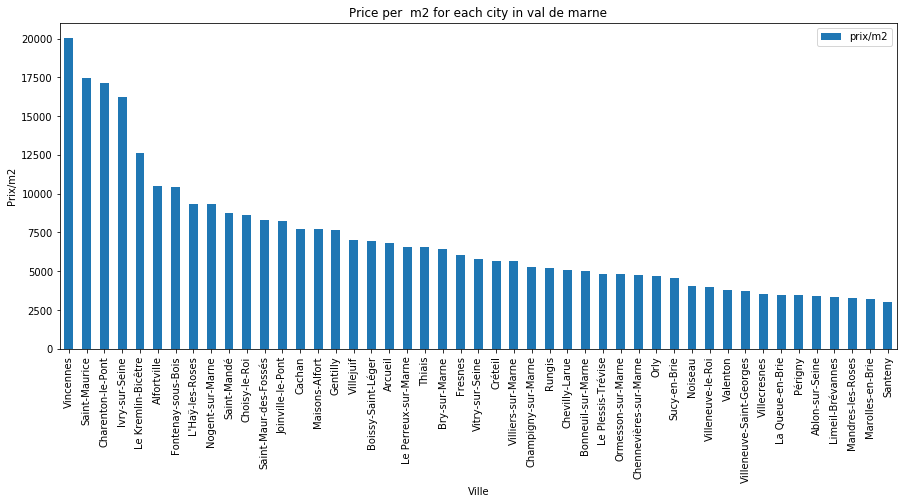

In [101]:
dw.set_index('Ville',inplace=True)

dw.plot(kind='bar', figsize=(15, 6))

plt.xlabel('Ville') # add to x-label to the plot
plt.ylabel('Prix/m2') # add y-label to the plot
plt.title('Price per  m2 for each city in val de marne') # add title to the plot

plt.show()

In [102]:
#dw=dw.astype({'CP': str})
#dw.head(10)

<h3>Choropleth with Prices<a id="6"></a>

In [103]:
# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(dw['prix/m2'].min(),
                              dw['prix/m2'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration


m = folium.Map(location=[48.80,2.40],zoom_start=12)
geo2=r'val_de_marne.json'

#folium.Choropleth().add_to(m)   ??

m.choropleth(
    geo_data=geo2,
    name='Prix au m2',
    data=dw,
    columns=['Code', 'prix/m2'],
    key_on='feature.properties.code',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    #fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='PRICE per city'
)
m


<h3>Foursquare<a id="7"></a>

In [104]:
CLIENT_ID = 'ZHE32WLAB4UBGOWKXIULNHAOJZHEF22BTJDE1KQUCEI25WRP'     # Foursquare ID
CLIENT_SECRET = 'XMIKVFZI45ON13QMPQLPORZ5NHHP0PZKS0US11HEKBCPO2KH' # Foursquare Secret
VERSION = '20180605'                                               # Foursquare API version

print('Foursquare credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Foursquare credentials:
CLIENT_ID: ZHE32WLAB4UBGOWKXIULNHAOJZHEF22BTJDE1KQUCEI25WRP
CLIENT_SECRET:XMIKVFZI45ON13QMPQLPORZ5NHHP0PZKS0US11HEKBCPO2KH


<h3>Venues for each station<a id="8"></a>
    

Fonction de recuperation

In [105]:
# function for all postcodes 
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['gare', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h3>Venues for each subway or RER station

In [106]:
vd = getNearbyVenues(names=db['gare'],latitudes=db['Latitude'],longitudes=db['Longitude'] )


Bérault
Créteil-Université
Villejuif-Louis Aragon
BRY-SUR-MARNE
CHOISY-LE-ROI
GENTILLY
LE PARC-DE-SAINT-MAUR
MAISONS-ALFORT-ALFORTVILLE
VAL-DE-FONTENAY
VILLENEUVE-SAINT-GEORGES
Créteil-L'Échat (Hôpital Mondor)
Villejuif-Léo Lagrange
FONTENAY-SOUS-BOIS
VILLENEUVE-LE-ROI
Château de Vincennes
Liberté
Maisons-Alfort-Stade
Villejuif-Paul Vaillant-Couturier
ARCUEIL-CACHAN
BAGNEUX
CHAMPIGNY
IVRY-SUR-SEINE
JOINVILLE-LE-PONT
LA VARENNE-CHENNEVIÈRES
LE VERT-DE-MAISONS
LES SAULES
ORLY VILLE
SAINT-MAUR-CRÉTEIL
VINCENNES
CRETEIL POMPADOUR
Créteil-Préfecture (Hôtel de Ville)
Mairie d'Ivry
Maisons-Alfort-Les Juilliottes
Saint-Mandé
Créteil-Pointe du Lac
ABLON
LAPLACE
RUNGIS-LA FRATERNELLE
VITRY-SUR-SEINE
VAL-DE-FONTENAY
École Vétérinaire de Maisons-Alfort
Charenton-Écoles
Le Kremlin-Bicêtre
Pierre Curie
BOISSY-SAINT-LEGER
LES ARDOINES
LES BOULLEREAUX-CHAMPIGNY
NOGENT-LE-PERREUX
NOGENT-SUR-MARNE
PONT-DE-RUNGIS-AÉROPORT D'ORLY
SUCY-BONNEUIL
VILLIERS-SUR-MARNE-PLESSIS-TRÉVISE
VILLENEUVE-TRIAGE


#### Let's check the size of the resulting dataframe

In [107]:
print(vd.shape)
vd.head(2)


(516, 7)


,gare,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bérault,48.845471,2.429205,La Cantine,48.846855,2.427938,French Restaurant
1,Bérault,48.845471,2.429205,Le Château des Vignerons,48.843945,2.431547,Bistro


<h4>Group by Station

In [108]:
vdm=vd.groupby('gare').count()
vdm.sort_values(by = 'gare', inplace = True,kind = 'mergesort')
vdm.head(5)

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
gare,,,,,,
ABLON,2,2,2,2,2,2
ARCUEIL-CACHAN,9,9,9,9,9,9
BAGNEUX,4,4,4,4,4,4
BOISSY-SAINT-LEGER,5,5,5,5,5,5
BRY-SUR-MARNE,4,4,4,4,4,4


In [109]:
print('There are {} uniques categories.'.format(len(vdm['Venue Category'].unique())))

There are 18 uniques categories.


## 3. Analyze Each Neighborhood <a id="4"></a>

In [110]:
# one hot encoding
vd_onehot = pd.get_dummies(vd[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vd_onehot['gare'] = vd['gare'] 

# move neighborhood column to the first column
fixed_columns = [vd_onehot.columns[-1]] + list(vd_onehot.columns[:-1])
vd_onehot = vd_onehot[fixed_columns]

vd_onehot.head(2)

,gare,Alternative Healer,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Astrologer,BBQ Joint,Bakery,Bar,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Brasserie,Burger Joint,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Canal Lock,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cycle Studio,Department Store,Diner,Doner Restaurant,Dry Cleaner,Electronics Store,Event Service,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Furniture / Home Store,Garden,Gas Station,General Entertainment,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Hobby Shop,Home Service,Hostel,Hotel,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Lounge,Market,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Movie Theater,Multiplex,Music School,Music Venue,Neighborhood,Optical Shop,Organic Grocery,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Pizza Place,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Recording Studio,Residential Building (Apartment / Condo),Restaurant,Salon / Barbershop,Sandwich Place,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Stadium,Spa,Sporting Goods Shop,Squash Court,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Toy / Game Store,Track Stadium,Train Station,Turkish Restaurant,Vacation Rental,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop
0,Bérault,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bérault,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [111]:
vd_onehot.shape

(516, 137)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [112]:
vd_grouped = vd_onehot.groupby('gare').mean().reset_index()
vd_grouped.head()


,gare,Alternative Healer,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Astrologer,BBQ Joint,Bakery,Bar,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Brasserie,Burger Joint,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Canal Lock,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cycle Studio,Department Store,Diner,Doner Restaurant,Dry Cleaner,Electronics Store,Event Service,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Flower Shop,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Furniture / Home Store,Garden,Gas Station,General Entertainment,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Hobby Shop,Home Service,Hostel,Hotel,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Lounge,Market,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Movie Theater,Multiplex,Music School,Music Venue,Neighborhood,Optical Shop,Organic Grocery,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Pet Store,Pharmacy,Photography Studio,Pizza Place,Plaza,Pool,Pool Hall,Portuguese Restaurant,Pub,Recording Studio,Residential Building (Apartment / Condo),Restaurant,Salon / Barbershop,Sandwich Place,Shopping Mall,Skating Rink,Smoke Shop,Snack Place,Soccer Stadium,Spa,Sporting Goods Shop,Squash Court,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Toy / Game Store,Track Stadium,Train Station,Turkish Restaurant,Vacation Rental,Vietnamese Restaurant,Water Park,Wine Bar,Wine Shop
0,ABLON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0
1,ARCUEIL-CACHAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0
2,BAGNEUX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0
3,BOISSY-SAINT-LEGER,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,

In [113]:
list(vd_grouped)

['gare',
 'Alternative Healer',
 'Arts & Crafts Store',
 'Arts & Entertainment',
 'Asian Restaurant',
 'Astrologer',
 'BBQ Joint',
 'Bakery',
 'Bar',
 'Basketball Court',
 'Basketball Stadium',
 'Beach',
 'Bed & Breakfast',
 'Beer Garden',
 'Big Box Store',
 'Bike Rental / Bike Share',
 'Bistro',
 'Bookstore',
 'Brasserie',
 'Burger Joint',
 'Bus Station',
 'Bus Stop',
 'Business Service',
 'Cafeteria',
 'Café',
 'Cajun / Creole Restaurant',
 'Canal Lock',
 'Castle',
 'Cheese Shop',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Climbing Gym',
 'Clothing Store',
 'Concert Hall',
 'Construction & Landscaping',
 'Convenience Store',
 'Cosmetics Shop',
 'Creperie',
 'Cycle Studio',
 'Department Store',
 'Diner',
 'Doner Restaurant',
 'Dry Cleaner',
 'Electronics Store',
 'Event Service',
 'Falafel Restaurant',
 'Farmers Market',
 'Fast Food Restaurant',
 'Financial or Legal Service',
 'Flower Shop',
 'Food & Drink Shop',
 'Food Court',
 'Food Truck',
 'French Restaurant',
 'Furniture / Home 

<h2>We keep only the types we are interested in 

In [114]:
vdm_grouped=vd_grouped.loc[:,[
 'gare' ,  
 'Arts & Entertainment',
 'Asian Restaurant',
 'Bakery',
 'Bar',
 'Bike Rental / Bike Share',
 'Bookstore',
 'Brasserie',
 'Café', 
 'Chinese Restaurant',
 'Climbing Gym',
 'Clothing Store',
 'Cosmetics Shop',
 'Creperie',
 'Diner',
 'Farmers Market',
 'Fast Food Restaurant',
 'Food & Drink Shop',
 'French Restaurant',
 'Gym', 
 'Hotel',
 'Indian Restaurant',
 'Italian Restaurant',
 'Japanese Restaurant', 
 'Market',
 'Multiplex',
 'Optical Shop',
 'Park', 
 'Perfume Shop',
 'Pharmacy',
 'Pizza Place', 
 'Pub',
 'Restaurant',
 'Sandwich Place',
 'Shopping Mall',
 'Smoke Shop',
 'Soccer Stadium',
 'Sporting Goods Shop',
 'Water Park',
 'Wine Bar',
 'Wine Shop'
 ]]   

In [115]:
vdm_grouped.head(5)

,gare,Arts & Entertainment,Asian Restaurant,Bakery,Bar,Bike Rental / Bike Share,Bookstore,Brasserie,Café,Chinese Restaurant,Climbing Gym,Clothing Store,Cosmetics Shop,Creperie,Diner,Farmers Market,Fast Food Restaurant,Food & Drink Shop,French Restaurant,Gym,Hotel,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Market,Multiplex,Optical Shop,Park,Perfume Shop,Pharmacy,Pizza Place,Pub,Restaurant,Sandwich Place,Shopping Mall,Smoke Shop,Soccer Stadium,Sporting Goods Shop,Water Park,Wine Bar,Wine Shop
0,ABLON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,ARCUEIL-CACHAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.111111,0.0,0.0,0.0,0.00,0.111111,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,BAGNEUX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.250000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
3,BOISSY-SAINT-LEGER,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.200000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.2,0.0,0.0,0.0
4,BRY-SUR-MARNE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.25,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0


#### Let's confirm the new size

In [116]:
vdm_grouped.shape

(52, 41)

#### Let's print each neighborhood along with the top 5 most common venues

In [117]:
num_top_venues = 5

for hood in vdm_grouped['gare']:
   # print("----"+hood+"----")
    temp = vdm_grouped[vdm_grouped['gare'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [118]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [119]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['gare']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
vdm_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
vdm_neighborhoods_venues_sorted['gare'] = vdm_grouped['gare']

for ind in np.arange(vdm_grouped.shape[0]):
    vdm_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vdm_grouped.iloc[ind, :], num_top_venues)

vdm_neighborhoods_venues_sorted.head()

,gare,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ABLON,Café,Wine Shop,Clothing Store,French Restaurant,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop
1,ARCUEIL-CACHAN,French Restaurant,Japanese Restaurant,Farmers Market,Park,Clothing Store,Food & Drink Shop,Fast Food Restaurant,Diner,Creperie,Cosmetics Shop
2,BAGNEUX,Japanese Restaurant,Farmers Market,Wine Shop,Gym,Food & Drink Shop,Fast Food Restaurant,Diner,Creperie,Cosmetics Shop,Clothing Store
3,BOISSY-SAINT-LEGER,French Restaurant,Sporting Goods Shop,Café,Climbing Gym,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop
4,BRY-SUR-MARNE,Italian Restaurant,Smoke Shop,Wine Shop,Climbing Gym,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop


## 4. Cluster Neighborhoods<a id="5"></a>

Run *k*-means to cluster the neighborhood into 5 clusters.

In [120]:
# set number of clusters
kclusters = 5

vdm_grouped_clustering = vdm_grouped.drop('gare', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vdm_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[:] 

array([4, 3, 3, 4, 0, 3, 2, 2, 1, 1, 3, 0, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1,
       2, 4, 1, 2, 3, 1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 2, 1, 1, 3, 3, 1, 1,
       0, 3, 3, 1, 0, 3, 1, 1])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [121]:
vdm_neighborhoods_venues_sorted.head()

,gare,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ABLON,Café,Wine Shop,Clothing Store,French Restaurant,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop
1,ARCUEIL-CACHAN,French Restaurant,Japanese Restaurant,Farmers Market,Park,Clothing Store,Food & Drink Shop,Fast Food Restaurant,Diner,Creperie,Cosmetics Shop
2,BAGNEUX,Japanese Restaurant,Farmers Market,Wine Shop,Gym,Food & Drink Shop,Fast Food Restaurant,Diner,Creperie,Cosmetics Shop,Clothing Store
3,BOISSY-SAINT-LEGER,French Restaurant,Sporting Goods Shop,Café,Climbing Gym,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop
4,BRY-SUR-MARNE,Italian Restaurant,Smoke Shop,Wine Shop,Climbing Gym,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop


In [122]:
# add clustering labels
vdm_neighborhoods_venues_sorted.insert(0, 'Cluster', kmeans.labels_)

vdm_merged = db

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
vdm_merged = vdm_merged.join(vdm_neighborhoods_venues_sorted.set_index('gare'), on='gare')

vdm_merged.head() # check the last columns!

,gare,type,ligne,Latitude,Longitude,Z,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bérault,Metro,1,48.845471,2.429205,1,3,Hotel,Italian Restaurant,Bakery,Bike Rental / Bike Share,Restaurant,Pizza Place,French Restaurant,Japanese Restaurant,Cosmetics Shop,Fast Food Restaurant
1,Créteil-Université,Metro,8,48.789978,2.450453,1,2,Park,Wine Shop,Gym,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop,Clothing Store
2,Villejuif-Louis Aragon,Metro,7,48.787563,2.367804,1,0,Indian Restaurant,Café,Gym,Clothing Store,French Restaurant,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie
3,BRY-SUR-MARNE,RER,RER A,48.844901,2.525923,1,0,Italian Restaurant,Smoke Shop,Wine Shop,Climbing Gym,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop
4,CHOISY-LE-ROI,RER,RER C,48.763787,2.411387,1,2,Pharmacy,Park,Wine Shop,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop,Clothing Store


In [123]:
list(vdm_merged)

['gare',
 'type',
 'ligne',
 'Latitude',
 'Longitude',
 'Z',
 'Cluster',
 '1st Most Common Venue',
 '2nd Most Common Venue',
 '3rd Most Common Venue',
 '4th Most Common Venue',
 '5th Most Common Venue',
 '6th Most Common Venue',
 '7th Most Common Venue',
 '8th Most Common Venue',
 '9th Most Common Venue',
 '10th Most Common Venue']

In [124]:
vdm_merged.dtypes

gare                       object
type                       object
ligne                      object
Latitude                  float64
Longitude                 float64
Z                           int64
Cluster                     int32
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

In [125]:
vdm_merged=vdm_merged.astype({'Cluster': 'int64'})

In [126]:
from branca.element import Template, MacroElement

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

a=rainbow[1]

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
                
       $( "#titlebox" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
                          
                
});

  </script>
</head>
<body>

<div id= 'titlebox' class='titlebox' style='position: absolute; z-index:9998; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; left: 100px; top: 20px;'>
 
 <div id= 'title' class='title'>
 Type of clusters 
</div>
</div>


 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend </div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:""" +rainbow[0]+ """;opacity:0.7;'></span>Italian - Wineshops</li>
    <li><span style='background:""" +rainbow[1]+ """;opacity:0.7;'></span> Asian - Wine-shop - Farmers market</li>
    <li><span style='background:""" +rainbow[2]+""";opacity:0.7;'></span>Gym - Park - Fast Food</li>
    <li><span style='background:""" +rainbow[3]+""";opacity:0.7;'></span>Diversity</li>
    <li><span style='background:""" +rainbow[4]+""";opacity:0.7;'></span>Fast food - Farmers market - Creperie</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>

  .titlebox{text-align: center;
    width :300px;
    height :50px;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 100%;}

 .titlebox .title
     {text-align: center;
   
    font-weight: bold;
    font-size: 100%;}

  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

#m.get_root().add_child(macro)


                 



<h3>Map of resulting clusters<a id="9"></a>

In [127]:
# create map
latitude=48.7842
longitude=2.4712
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.LatLngPopup().add_to(map_clusters)   # popup lat long


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vdm_merged['Latitude'], vdm_merged['Longitude'], vdm_merged['gare'], vdm_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=500,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
folium.PolyLine(cont_xy,color='black', popup='Val de Marne').add_to(map_clusters)
map_clusters.get_root().add_child(macro)       
map_clusters

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

<h2>Analyse of  the resulting clusters<a id="10"></a>

#### Cluster 1 Italian - Wineshops

In [128]:
vdm_merged.loc[vdm_merged['Cluster'] == 0, vdm_merged.columns[[0,1] + list(range(6, vdm_merged.shape[1]))]]

,gare,type,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Villejuif-Louis Aragon,Metro,0,Indian Restaurant,Café,Gym,Clothing Store,French Restaurant,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie
3,BRY-SUR-MARNE,RER,0,Italian Restaurant,Smoke Shop,Wine Shop,Climbing Gym,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop
10,Créteil-L'Échat (Hôpital Mondor),Metro,0,Italian Restaurant,Bakery,Wine Shop,Clothing Store,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop
23,LA VARENNE-CHENNEVIÈRES,RER,0,Pizza Place,Italian Restaurant,Creperie,Café,Climbing Gym,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Cosmetics Shop
47,NOGENT-LE-PERREUX,RER,0,Italian Restaurant,Wine Shop,Bar,Restaurant,Café,Clothing Store,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner
52,VILLENEUVE-TRIAGE,RER,0,Water Park,Restaurant,Wine Shop,Climbing Gym,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop


#### Cluster 2  Asian, Wine-shop, Farmers market

In [129]:
vdm_merged.loc[vdm_merged['Cluster'] == 1, vdm_merged.columns[[0,1] + list(range(6, vdm_merged.shape[1]))]]

,gare,type,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,GENTILLY,RER,1,Japanese Restaurant,Bike Rental / Bike Share,Café,Park,Wine Shop,Cosmetics Shop,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner
6,LE PARC-DE-SAINT-MAUR,RER,1,Asian Restaurant,Bakery,Indian Restaurant,Japanese Restaurant,Brasserie,Café,Wine Shop,Creperie,Food & Drink Shop,Fast Food Restaurant
7,MAISONS-ALFORT-ALFORTVILLE,RER,1,Asian Restaurant,Bakery,Fast Food Restaurant,Brasserie,Wine Shop,Cosmetics Shop,French Restaurant,Food & Drink Shop,Farmers Market,Diner
9,VILLENEUVE-SAINT-GEORGES,RER,1,Bakery,Café,Wine Shop,Clothing Store,French Restaurant,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie
12,FONTENAY-SOUS-BOIS,RER,1,Food & Drink Shop,Wine Shop,Wine Bar,French Restaurant,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop,Clothing Store
13,VILLENEUVE-LE-ROI,RER,1,Chinese Restaurant,Wine Shop,Clothing Store,French Restaurant,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop
15,Liberté,Metro,1,Hotel,Bike Rental / Bike Share,Park,Pharmacy,French Restaurant,Chinese Restaurant,Smoke Shop,Bakery,Bookstore,Brasserie
17,Villejuif-Paul Vaillant-Couturier,Metro,1,Chinese Restaurant,Wine Shop,Clothing Store,French Restaurant,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop
22,JOINVILLE-LE-PONT,RER,1,Wine Shop,Wine Bar,French Restaurant,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop,Clothing Store
26,ORLY VILLE,RER,1,Asian Restaurant,Shopping Mall,Wine Shop,Climbing Gym,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop


#### Cluster 3  Gym - Park - Fast Food

In [130]:
vdm_merged.loc[vdm_merged['Cluster'] == 2, vdm_merged.columns[[0,1] + list(range(6, vdm_merged.shape[1]))]]

,gare,type,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Créteil-Université,Metro,2,Park,Wine Shop,Gym,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop,Clothing Store
4,CHOISY-LE-ROI,RER,2,Pharmacy,Park,Wine Shop,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop,Clothing Store
20,CHAMPIGNY,RER,2,Pizza Place,Pharmacy,Park,Wine Shop,Food & Drink Shop,Asian Restaurant,Fast Food Restaurant,Farmers Market,Diner,Creperie
21,IVRY-SUR-SEINE,RER,2,Indian Restaurant,Park,Wine Shop,Clothing Store,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop
24,LE VERT-DE-MAISONS,RER,2,Park,Wine Shop,Gym,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop,Clothing Store
25,LES SAULES,RER,2,Park,Wine Shop,Gym,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop,Clothing Store
37,RUNGIS-LA FRATERNELLE,RER,2,Pizza Place,Park,French Restaurant,Bakery,Bar,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie


#### Cluster 4  Diversity

In [131]:
vdm_merged.loc[vdm_merged['Cluster'] == 3, vdm_merged.columns[[0,1] + list(range(6, vdm_merged.shape[1]))]]

,gare,type,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bérault,Metro,3,Hotel,Italian Restaurant,Bakery,Bike Rental / Bike Share,Restaurant,Pizza Place,French Restaurant,Japanese Restaurant,Cosmetics Shop,Fast Food Restaurant
8,VAL-DE-FONTENAY,RER,3,Hotel,French Restaurant,Fast Food Restaurant,Sandwich Place,Pizza Place,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Perfume Shop,Shopping Mall
11,Villejuif-Léo Lagrange,Metro,3,Hotel,Wine Bar,Italian Restaurant,Japanese Restaurant,Optical Shop,Climbing Gym,Cosmetics Shop,Fast Food Restaurant,Farmers Market,Diner
14,Château de Vincennes,Metro,3,Japanese Restaurant,Restaurant,French Restaurant,Hotel,Italian Restaurant,Fast Food Restaurant,Bar,Diner,Pub,Cosmetics Shop
16,Maisons-Alfort-Stade,Metro,3,Pizza Place,Bar,Japanese Restaurant,French Restaurant,Bakery,Cosmetics Shop,Food & Drink Shop,Fast Food Restaurant,Asian Restaurant,Farmers Market
18,ARCUEIL-CACHAN,RER,3,French Restaurant,Japanese Restaurant,Farmers Market,Park,Clothing Store,Food & Drink Shop,Fast Food Restaurant,Diner,Creperie,Cosmetics Shop
19,BAGNEUX,RER,3,Japanese Restaurant,Farmers Market,Wine Shop,Gym,Food & Drink Shop,Fast Food Restaurant,Diner,Creperie,Cosmetics Shop,Clothing Store
28,VINCENNES,RER,3,French Restaurant,Hotel,Bike Rental / Bike Share,Italian Restaurant,Restaurant,Japanese Restaurant,Bookstore,Pizza Place,Cosmetics Shop,Fast Food Restaurant
33,Saint-Mandé,Metro,3,French Restaurant,Italian Restaurant,Japanese Restaurant,Restaurant,Indian Restaurant,Market,Café,Hotel,Sandwich Place,Bar
39,VAL-DE-FONTENAY,RER,3,Hotel,French Restaurant,Fast Food Restaurant,Sandwich Place,Pizza Place,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Perfume Shop,Shopping Mall


#### Cluster 5 Fast food - Farmers market - Creperie


In [132]:
vdm_merged.loc[vdm_merged['Cluster'] == 4, vdm_merged.columns[[0,1] + list(range(6, vdm_merged.shape[1]))]]

,gare,type,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,ABLON,RER,4,Café,Wine Shop,Clothing Store,French Restaurant,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop
44,BOISSY-SAINT-LEGER,RER,4,French Restaurant,Sporting Goods Shop,Café,Climbing Gym,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop
45,LES ARDOINES,RER,4,Arts & Entertainment,Café,Clothing Store,French Restaurant,Food & Drink Shop,Fast Food Restaurant,Farmers Market,Diner,Creperie,Cosmetics Shop
